# Analyze customer data from Austin, TX. 

In this lab, we will analyze various features of customer energy usage data from the Pecan Street dataset. The dataset we aim to explore is for the month of January 2017 from various customers in Austin, TX.

Distinguish which houses have rooftop photovoltaic (PV) panels and which ones do not. For the houses that do not have PV panels, try to predict how much money they would save, given Austin's retail energy rates.

Given the temperature profile, can you predict which houses have AC?

In [2]:
# Start with customary imports.

import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model, svm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Understand and parse the dataset

There are two csv files that we will utilize in this lab:
1. 'dataport-metadata.csv': It contains the details of what data is available from each house in the entire Pecan Street dataset.
2. 'July2017.csv': It contains the energy data from houses in Austin for the month of July.

### Parse the metadata file.

Only consider customers from Austin, TX for which electricity usage data is present.


In [4]:
# Load the 'metadata' file that contains information about individual houses into a pandas dataframe.
dfCityCustomers = pd.read_csv("dataport-metadata.csv", index_col=0)

# Only consider the houses that are in Austin and have power consumption data.
dfCityCustomers = dfCityCustomers.loc[(dfCityCustomers['city'] == 'Austin') & (dfCityCustomers['use'] == 'yes')]

# Restrict attention to useful columns.
dfCityCustomers = dfCityCustomers[['date_enrolled', 'date_withdrawn', 
                                   'building_type', 'total_square_footage', 'first_floor_square_footage',
                                   'pv', 'air1', 'air2', 'air3', 'airwindowunit1',
                                   'gen', 'use', 'grid']]

# Replace binary data with zeros and ones.
binaryColumns = ['pv', 'air1', 'air2', 'air3', 'airwindowunit1', 'gen', 'use', 'grid']
for bColumn in binaryColumns:
    dfCityCustomers[bColumn] = dfCityCustomers[bColumn].map({'yes' : 1}).fillna(0)

start_day = datetime.datetime.strptime('2017-07-01', '%Y-%m-%d').date()
    
dfCityCustomers['date_enrolled'] = [datetime.datetime.strptime(x, "%Y-%m-%d") 
                                    for x in dfCityCustomers['date_enrolled']]

dfCityCustomers = dfCityCustomers.loc[(dfCityCustomers['date_enrolled'] <= '2017-07-01')]
print("Parsed the metadata file successfully.")

Parsed the metadata file successfully.


### Parse the energy usage data.

Here, we shall clean the data. 

1. The data downloaded from dataport.cloud has a mislabeled colmn. Correct that.
2. Split the 'localhour' field into two fiels: actual date and an hour of day.
3. Only choose data from households that are 'Single-Family Homes'.
4. Make sure there is data from 31 days.
5. Ensure that the metadata includes the square footage for the entire home and its first floor.

Finally, create a pandas dataframe where indices are house id's.

In [5]:
# Load the data from Jan 2017 from houses in Texas.
dfData = pd.read_csv("July2017.csv")

# Cleanup item 1. Alter the column names because there is an error in the downloaded data. The column names
# 'dataid' and 'localhour' are switched in the .csv file. Correct it. 
# Cleanup item 2. Split the hour and the day in the field 'localhour' and convert the date to an 
# actual datetime object.

dfData.columns = [x.lstrip() for x in dfData.columns]
dfData = dfData[['dataid', 'localhour', 'use', 'grid', 'gen', 'air1', 'air2', 'air3', 'airwindowunit1']]
dfData.columns = ['date', 'dataid', 'use', 'grid', 'gen', 'air1', 'air2', 'air3', 'airwindowunit1']

dfData['hour'] = [datetime.datetime.strptime(x[:-3], "%Y-%m-%d %H:%M:%S").hour for x in dfData['date']]
dfData['date'] = [datetime.datetime.strptime(x[:-3], "%Y-%m-%d %H:%M:%S").date() for x in dfData['date']]

# Create a dataframe where indices are house id's.
dfData_houses = pd.DataFrame(columns=['ac', 'pv', 'area', 'area_floor', 'data'])

for house_id in dfData['dataid'].unique():
    
    # Make sure that each house with consumption data is also in metadata.
    if house_id in dfCityCustomers.index.values:
        dfData_one_house = dfData.loc[dfData['dataid'] == house_id]

        # Cleanup item 3, 4, 5.
        if ((len(dfData_one_house) >= 24 * 31) & 
        (np.sum(dfData_one_house['use'].values) != 0) & 
        (dfCityCustomers.loc[house_id, 'building_type'] == 'Single-Family Home') & 
        (np.isnan(dfCityCustomers.loc[house_id, 'total_square_footage']) == False) & 
        (np.isnan(dfCityCustomers.loc[house_id, 'first_floor_square_footage']) == False)):
            
            # Create a pandas dataframe with house id's as indices and has the following items: 
            # 1. Binary status: "ac", "pv".
            # 2. Total square footrage, and the square footage of the first floor.
            
            is_ac_in_house =  (dfCityCustomers.loc[house_id, 'air1'] 
                               or dfCityCustomers.loc[house_id, 'air2']
                               or dfCityCustomers.loc[house_id, 'air3']
                               or dfCityCustomers.loc[house_id, 'airwindowunit1']
                              )
            
            dfData_houses.loc[house_id] = [is_ac_in_house, 
                                           dfCityCustomers.loc[house_id, 'pv'],
                                           dfCityCustomers.loc[house_id, 'total_square_footage'],
                                           dfCityCustomers.loc[house_id, 'first_floor_square_footage'],
                                           dfData_one_house
                                          ]

# Define a function that retrieves the hourly energy profile from the column in "field" from a
# specific house and day. The day is measured as number of days since the start date of Jan 1, 2017.

def energy_day(house_id, day, field): 
    date_day = start_day + datetime.timedelta(days=day)
    dfData_house = dfData_houses.loc[house_id, 'data']
    return dfData_house.loc[dfData_house['date'] == date_day].sort_values(by=['hour'])[field].values

# Define a function that retrieves the aggregate energy consumed (or produced) as detailed in the column 
# named "field" from a specific house over all days.

def total_energy_all_days(house_id, field): 
    total_energy = 0
    for day in range(31):
        total_energy += np.sum(energy_day(house_id, day, field))
    return total_energy


# Cleanup item 4 continued: Delete data from houses where the date and hour do not perfectly 
# align with the 31 days in July, and hours being from 0 to 23.
house_ids_to_delete = []
for house_id in dfData_houses.index.values:
    for day in range(31):
        if len(energy_day(house_id, day, 'grid')) != 24:
            house_ids_to_delete.append(house_id)
            continue

dfData_houses.drop(house_ids_to_delete, inplace=True)

print("Data loaded and parsed successfully from %d single-family homes." % (len(dfData_houses)))

del dfData , dfCityCustomers           

Data loaded and parsed successfully from 222 single-family homes.


## Distinguish houses with rooftop solar panels from daily energy usage profile.

Take data of energy drawn from the grid for 10 days and do logistic regression.

### Q1. Explain Logistic regression. (10 points)

Logistic Regression is a linear model that uses the sigmoid activation function and calculates the error using the cross-entropy loss function. When we have a binary label classification, we use the sigmoid function (1 / (1 - e^(WX+B) ) and in a multi-label classification, we use the softmax function. Values that are negative will be predicted as label 0 while values that are positive will be labeled as 1. 

In [6]:
print("Number of houses with PV panels = %d" % (len(dfData_houses.loc[dfData_houses['pv'] == 1])) )
print("Number of houses without PV panels = %d" % (len(dfData_houses.loc[dfData_houses['pv'] == 0])) )

XX = []
YY = []

days_data = random.sample(range(31), 10)

for house_id in dfData_houses.index.values:
    XX.append(np.ravel([energy_day(house_id, day, 'grid') for day in days_data]))
    YY.append(dfData_houses.loc[house_id, 'pv'])

YY = np.reshape(YY, (-1, 1))

train_X, test_X, train_Y, test_Y = train_test_split(XX, YY, test_size=.2, shuffle=True)

del XX, YY

Number of houses with PV panels = 146
Number of houses without PV panels = 76


### Q2. Design the neural network. In the next cell, fill in the missing pieces. (30 points)


### Q3.  Print the classification report on the test data. The function 'classification_report' from 'sklearn.metrics' might prove useful. (10 points)

In [11]:
n_inputs = np.shape(train_X)[1]
n_outputs = np.shape(train_Y)[1]

input_NN = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs])
target_output_NN = tf.placeholder(dtype=tf.float32, shape=[None, n_outputs])

weight = tf.Variable(tf.truncated_normal(shape=[n_inputs, n_outputs]) )
bias = tf.Variable(tf.zeros(n_outputs)  )

output_NN = tf.nn.sigmoid( tf.matmul(tf.cast(input_NN, tf.float32), weight) + bias )

# Enter code here (hint: tf.nn.sigmoid and tf.nn.sigmoid.cros... might be useful)
loss = tf.reduce_sum( tf.nn.sigmoid_cross_entropy_with_logits( labels = target_output_NN, logits = output_NN) ) 
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

prediction_NN = tf.round(tf.sigmoid(output_NN))
correct_predictions_NN = tf.cast(tf.equal(prediction_NN, target_output_NN), dtype=tf.float32)
accuracy_NN = tf.reduce_mean(correct_predictions_NN)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    n_epochs = 20000

    print ("Start neural network training.")
    for n in range(n_epochs):
        _, loss_epoch = sess.run([optimizer, loss],
                                feed_dict={input_NN: train_X, target_output_NN: train_Y})
        if (n+1) % 1000 == 0:
            print("Done with %d epochs. Loss in last epoch = %1.3f" % (n+1, loss_epoch))

    test_prediction, test_accuracy = sess.run([prediction_NN, accuracy_NN], feed_dict={input_NN: test_X, target_output_NN: test_Y})
    print("Accuracy of logistic regression on test data = %.2f percent." % (test_accuracy * 100))

Start neural network training.
Done with 1000 epochs. Loss in last epoch = 91.392
Done with 2000 epochs. Loss in last epoch = 87.573
Done with 3000 epochs. Loss in last epoch = 86.952
Done with 4000 epochs. Loss in last epoch = 86.826
Done with 5000 epochs. Loss in last epoch = 86.766
Done with 6000 epochs. Loss in last epoch = 86.407
Done with 7000 epochs. Loss in last epoch = 85.576
Done with 8000 epochs. Loss in last epoch = 83.982
Done with 9000 epochs. Loss in last epoch = 83.935
Done with 10000 epochs. Loss in last epoch = 83.174
Done with 11000 epochs. Loss in last epoch = 83.139
Done with 12000 epochs. Loss in last epoch = 82.506
Done with 13000 epochs. Loss in last epoch = 82.098
Done with 14000 epochs. Loss in last epoch = 81.110
Done with 15000 epochs. Loss in last epoch = 80.726
Done with 16000 epochs. Loss in last epoch = 80.711
Done with 17000 epochs. Loss in last epoch = 80.699
Done with 18000 epochs. Loss in last epoch = 80.688
Done with 19000 epochs. Loss in last epoch

In [12]:
# Enter code here
print( classification_report(test_Y, test_prediction) )

              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90        17
         1.0       0.90      1.00      0.95        28

   micro avg       0.93      0.93      0.93        45
   macro avg       0.95      0.91      0.93        45
weighted avg       0.94      0.93      0.93        45



### Q4. Based on the classification report you obtain, your classifier is better in which of the following tasks? (20 points)
1. If it identifies a house to have a PV panel, then it has a PV panel.
2. If there is a PV panel, then it identifies that it has a PV panel.

Furhtermore, complete the code below to plot the energy drawn from the grid from houses with and without PV panels.

According to data listed for label = 1, the recall is greater than the precision value. Therefore the classifier did better on task #2 (when there is a PV panel, it's able to identify it having a PV Panel)

[3538, 7850, 668, 8419, 3506]


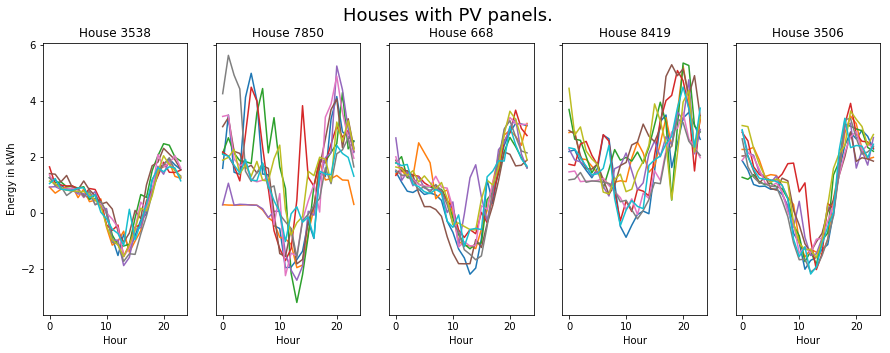

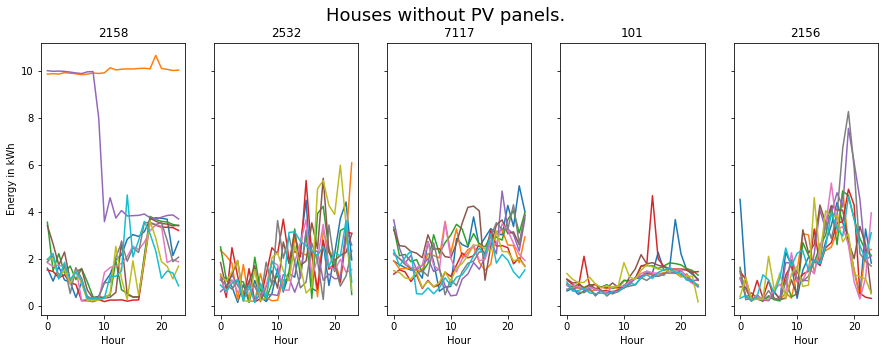

In [76]:
# Plot energy drawn from grid for houses with PV's.
house_id_pv = random.sample(list(dfData_houses.loc[dfData_houses['pv'] == 1].index.values), 5)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,5))
print(house_id_pv)
for tt, house_id in enumerate(house_id_pv):
    for day in days_data:
        # Enter code here
        axs[tt].plot( energy_day(house_id, day,  'grid' ) ) 
        axs[tt].set_title("House " + str(house_id))
        
fig.suptitle('Houses with PV panels.', fontsize=18)

for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Energy in kWh')
for ax in axs.flat:
    ax.label_outer()

house_id_not_pv = random.sample(list(dfData_houses.loc[dfData_houses['pv'] == 0].index.values), 5)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,5))
axs = axs.ravel()

for tt, house_id in enumerate(house_id_not_pv):
    for day in days_data:
        # Enter code here
        axs[tt].plot( energy_day(house_id, day,  'grid' ) ) 
        axs[tt].set_title(house_id)

fig.suptitle('Houses without PV panels.', fontsize=18)        

for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Energy in kWh')
for ax in axs.flat:
    ax.label_outer()

### Q5. Design a classifier to distinguish between houses with and without PV based on the plots. Print your classification report, and compare it with logistic regression. (20 points, bonus) 

The classifier used to distinguish houses with and without PV was a SVM using a RBF kernel. As seen in the plots above, houses with PV panels have energy that's within the negative power values while houses with PV panels have power greater than 0 kWh. The chosen classifier ended up producing similar results to the logistic regression as seen in the classification report/accuracy.   

In [69]:
# Compare the performance of a neural network based classifier with an educated guess.
classifier = svm.SVC( kernel = 'rbf', degree = 3, max_iter = 100000, gamma = 'auto'  )
classifier.fit(train_X, train_Y)

pred_y = classifier.predict(test_X) 
print( classifier.score(test_X, test_Y))
print( classification_report(test_Y, pred_y) )


0.9555555555555556
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        17
         1.0       0.96      0.96      0.96        28

   micro avg       0.96      0.96      0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## What appliance consumes the most power?

Thermal loads are almost always the appliances that consume the most power. The amount of power they draw also typically grows with the size of the house. In the following, we have two tasks:
1. What percentage of energy consumption is due to an air conditioner?
2. Can you derive a linear relationship between household square footage and power consumption from air conditions in July 2017?

Text(0.5, 1.0, 'Histogram of AC usage as a fraction of total power consumption.')

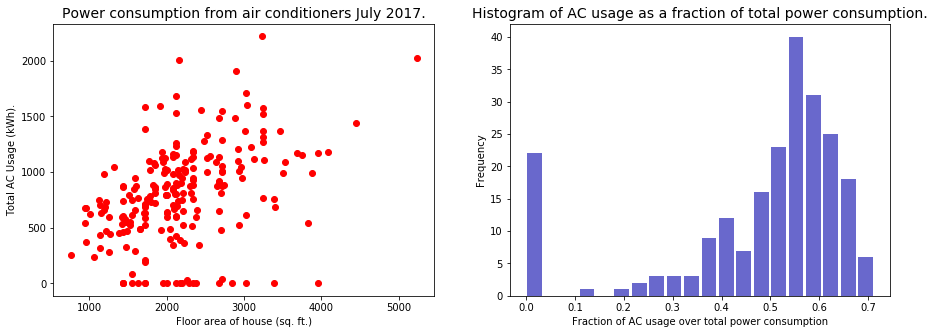

In [6]:
for house_id in dfData_houses.index.values:
    dfData_houses.at[house_id, 'ac_usage'] = (total_energy_all_days(house_id, 'air1') + 
                                              total_energy_all_days(house_id, 'air2') + 
                                              total_energy_all_days(house_id, 'air3') +
                                              total_energy_all_days(house_id, 'airwindowunit1')
                                          )
    dfData_houses.at[house_id, 'total_usage'] = total_energy_all_days(house_id, 'use')

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].scatter(dfData_houses['area'].values, 
               dfData_houses['ac_usage'].values, 
               c='r', marker='o', label='AC usage'
              )
axs[0].set_xlabel('Floor area of house (sq. ft.)')
axs[0].set_ylabel('Total AC Usage (kWh).')
axs[0].set_title('Power consumption from air conditioners July 2017.', fontsize=14)

axs[1].hist(x=np.divide(dfData_houses['ac_usage'], dfData_houses['total_usage']), bins=20, alpha=0.6, color='#0504aa', rwidth=0.85)
axs[1].set_xlabel('Fraction of AC usage over total power consumption')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of AC usage as a fraction of total power consumption.', fontsize=14)

### Q6. Based on the above analysis, will you expect the total power consumption from customers to be more or less in October as compared to that in July? How does the above analysis compare to your analysis in Lab 1 on aggregate load prediction in Texas? (10 points)

<br> The total power consumption for October would be lower than July as October is more colder than July which means that there will be less AC usage and based on the histogram, majority of people's power consumption comes from AC. Therefore, reducing the power consumption of AC will decrease the overall total power consumption. </br> 

<br> In lab 1, we see that the month of January had lower power demand compared to the month of August. This supports what we said above in which we assumed that a majority of total power consumption comes from AC. Just like the reasoning stated above, August has a hotter temperatures compared to January and therefore will have more AC power consumption which will then lead to having a higher total power consumption. </br> 

### Q7. Can you think of a business case for the above histogram? (10 points, bonus)

<br> As seen in the first graph, the bigger the floor area of a house, the higher the AC usage becomes (this relationship seems closely linear). The same can be said for the histogram as we can see that a majoirty of people uses their total power consumptions from AC. The easiest business proposition here would be to create a system where it will be able to manage the power consumption of AC usage better than what's being currently used in the users home. The main selling point would be being able to reduce the amount of power consumed during those months and therefore shows people that they can save money by using our model/idea. If we know the specific individuals for each block of the hisogram, we will be able to know the social status of the users and find which demographic we can target our model/idea towards to. Our model/idea should be able to maintain the AC's power output and from its prediction of power demand, be able to adjust the AC's power consumption as well. The model can be on either a one time fee or monthly subscription. </br>  

### Compute monthly electric bills for each customer

Your electricity bill consists of various charges. These charges depend on the utility company you pay your electricity bill to. In Champaign, IL, your distribution utility company is Ameren. In Austin, a major distribution utility company is Austin Energy. Their bill structure is discussed in the following link:
https://austinenergy.com/ae/residential/rates/residential-electric-rates-and-line-items

Calculate the monthly bill of each household.

1. For each customer, compute the total energy consumed, available in the data field "use" over the month. Use the tiered rate structure to compute the total power bill for energy consumption.

2. For customers with PV panels, compute the total energy produced by the PV panels. Assume that Ameren Energy pays 9.7 cents/kWh for such production, and subtract the amount for solar power production from the power bill.

In [15]:
# Define a function that computes the electricity bill according to the structure defined by Austin Energy.

def electricity_bill(consumption):
    customer_charge = 10
    power_supply_adjustment = 2.895 * consumption / 100.0
    community_benefit_charge = (0.154 + 0.124 + 0.335) * consumption / 100.0
    regulatory_charge = 1.342 * consumption / 100.0
    
    tier_rate = [2.801, 5.832, 7.814, 9.314, 10.814]    
    tier_limits = [0, 500, 1000, 1500, 2500, math.inf]
    n_tiers = 5
    
    energy_charge = 0
    
    for tier in range(n_tiers):
        consumption_tier = min(max(consumption, tier_limits[tier]), tier_limits[tier + 1]) - tier_limits[tier]
        energy_charge += consumption_tier * tier_rate[tier] / 100.0
        
    return float('%.2f'%(1.01 * (energy_charge + customer_charge + power_supply_adjustment + community_benefit_charge
                   + regulatory_charge)))

for house_id in dfData_houses.index.values:
    dfData_houses.at[house_id, 'consumption_bill'] = electricity_bill(dfData_houses.loc[house_id, 'total_usage'])
    dfData_houses.at[house_id, 'pv_savings'] = total_energy_all_days(house_id, 'gen') * 9.7 / 100.0
    dfData_houses.at[house_id, 'electricity_bill'] = dfData_houses.loc[house_id, 'consumption_bill'] - dfData_houses.loc[house_id, 'pv_savings']
    
    
print("Electricity bill computed for all customers.")

Electricity bill computed for all customers.


### What is a good indicator of electricity bill for consumption and savings from PV?

Electricity consumption significantly depends on floor area of a house. The dependency is even stronger, if the house is equipped with central AC. A scatter plot of the consumption bill against floor area reveals this dependency.

Monetary savings from PV panels depends on how many PV panels there are, which way they face, and how that relates to solar insolation. The number of panels installed largely depends on the roof area. The floor area of one of the floors is a good indicator. 

Text(0.5, 1.0, 'Monthly savings from PV panels over July 2017.')

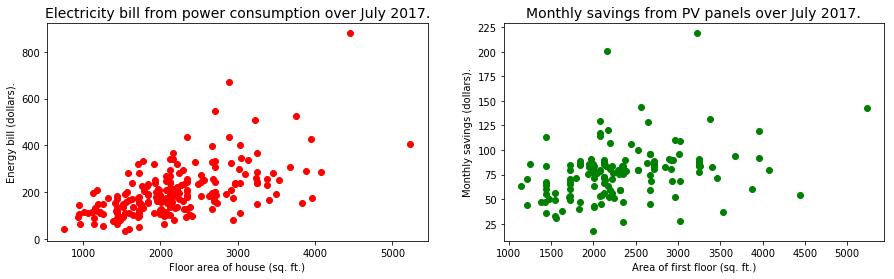

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

# Plot of electricity bill for consumption against the square footage of the house.

axs[0].scatter(dfData_houses['area'].values, 
               dfData_houses['consumption_bill'].values, 
               c='r', marker='o', label='Electricity bill from consumption'
           )
axs[0].set_xlabel('Floor area of house (sq. ft.)')
axs[0].set_ylabel('Energy bill (dollars).')
axs[0].set_title('Electricity bill from power consumption over July 2017.', fontsize=14)

# Plot monetary savings from PV against the area of the first floor.

houses_without_pv = dfData_houses.loc[dfData_houses['pv'] == 0].index.values
houses_with_pv = dfData_houses.loc[dfData_houses['pv'] == 1].index.values

axs[1].scatter(dfData_houses.loc[houses_with_pv, 'area'].values, 
               dfData_houses.loc[houses_with_pv, 'pv_savings'].values, 
               c='g', marker='o', label='Savings from PV')

axs[1].set_xlabel('Area of first floor (sq. ft.)')
axs[1].set_ylabel('Monthly savings (dollars).')
axs[1].set_title('Monthly savings from PV panels over July 2017.', fontsize=14)

### Given the square footage of the house and the first floor, compute the electricity bill with and without PV.
 
Perform a linear regression on electricity bill and monthly savings from PV. Use the linear fits to compute the anticipated electricity bill with and without PV. Report your anticipated percentage savings with PV.

Use the data:
1. Square footage of entire house = 2450 sq. ft.
2. Square footage of first floor = 1380 sq. ft.

### Q8. Fill in the gaps below. Let's say you have $\$18,000$ to spend on a PV and get $\$2,500 $ in solar rebate . How long will it take (in years) for you to recover the initial investment?  (20 points)

The first linear regression is used to predict the electricity bill with no PV (in this case Electricity Bill = Consumption Bill) and the second linear regression (with inputs as area_floor and pv_savings) is used to predict the PV savings which will give us the electricity bill with PV (consumption_bill - pv_savings). PV savings will be our net gain for that month and we can then calculate how many months it takes to reach 18,000 - 2,500 = $15,500 back.  

In [26]:
area_house = 2450
area_first_floor = 1380

# Power/Consumption Bill 
XX = dfData_houses['area'].values.reshape(-1, 1) 
YY = dfData_houses['consumption_bill'].values.reshape(-1, 1)

model_consumption = linear_model.LinearRegression()
model_consumption.fit(XX, YY)

no_pv_bill = model_consumption.predict(np.array([area_house]).reshape(-1, 1)) ; 
print("Predicted Power bill = $%.2f" %  no_pv_bill )

# Enter code here to compute predicted savings from PV 

print("Predicted Electricity Bill without PV = $%.2f" %  no_pv_bill )

XX = dfData_houses.loc[houses_with_pv, 'area_floor'].values.reshape(-1, 1) 
YY = dfData_houses.loc[houses_with_pv, 'pv_savings'].values.reshape(-1, 1)

model_pv = linear_model.LinearRegression()
model_pv.fit(XX, YY)

with_pv_bill = model_pv.predict(np.array([area_first_floor]).reshape(-1, 1) ) 
print("Predicted Electricity Bill with PV = $%.2f" % (no_pv_bill - with_pv_bill) )

del XX, YY

Predicted Power bill = $221.84
Predicted Electricity Bill without PV = $221.84
Predicted Electricity Bill with PV = $147.93


In [27]:
num_month = (18000 - 2500) / with_pv_bill  
num_year = num_month / 12 

print( "Number of Years to take to Recover Initial Investment = %.2f" % num_year )

Number of Years to take to Recover Initial Investment = 17.48
